In [1]:
%matplotlib notebook
import numpy as np
import pickle as pk
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ensemble_idx = [1, 2, 3, 4]
pred_ensemble = []
for idx in ensemble_idx:
    with open(f'/workspaces/pyskl/work_dirs/stgcn_ntu60_coco_{idx}/last_pred.pkl', 'rb') as f:
        pred = pk.load(f)
    pred_ensemble.append(pred)

In [3]:
with open('/workspaces/pyskl/data_generate/datasets_ntu60/ntu60_hrnet.pkl', 'rb') as f:
    gt = pk.load(f)
print(gt.keys())
print(gt['split'].keys())

true_num_ = 0
true_num = 0
true_uncert = []
false_uncert = []
for idx, item in enumerate(gt['split']['xsub_val']):
    
    # 根据gt中sub_val的划分，获取真值
    for i in gt['annotations']:
#         print(i['frame_dir'])
        if item == i['frame_dir']:
            gt_label = i['label']
            break
            
    all = np.concatenate(
        ([pred_ensemble[i][idx][np.newaxis,...] for i in range(len(pred_ensemble))]),
        axis = 0
    )
        
    # disagreement / uncertainty
    uncertainty = 0
    pred_mean = np.mean(all, axis=0)
    for each in all:
        uncertainty += np.sum(each * (np.log(each+1e-20) - np.log(pred_mean+1e-20)))
    uncertainty = uncertainty / len(ensemble_idx)
        
    # 单个模型的预测结果
    pred = all[1]
    pred_label = np.argmax(pred)
    if gt_label == pred_label:
        true_num += 1
    
    # 集成模型的预测结果
    pred_ = np.mean(all, axis=0)
    pred_label_ = np.argmax(pred_)
    if gt_label == pred_label_:
        true_num_ += 1
        true_uncert.append(uncertainty)
    else:
        false_uncert.append(uncertainty)
        
#     if gt_label != pred_label and gt_label == pred_label_:
#         print(item)
    
#     if gt_label != pred_label:
#         print(item)


test_num = len(gt['split']['xsub_val'])
print(true_num/test_num)
print(true_num_/test_num)

dict_keys(['split', 'annotations'])
dict_keys(['xsub_train', 'xsub_val', 'xview_train', 'xview_val'])
0.8889428034208771
0.8967671498756596


<IPython.core.display.Javascript object>


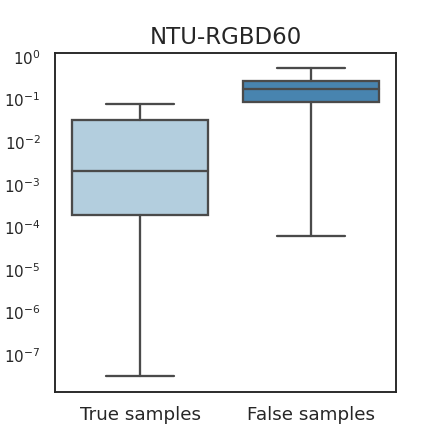

In [15]:
false_uncert = sorted(false_uncert, reverse=True)
false_uncert = list(itertools.islice(itertools.cycle(false_uncert), len(true_uncert)))
# false_uncert = false_uncert * (len(true_uncert) // len(false_uncert)) + false_uncert[:len(true_uncert) % len(false_uncert)]


df = pd.DataFrame({'True samples': true_uncert, 'False samples': false_uncert})

plt.figure(figsize=(4, 4))  # Set the figure size
sns.set(style="white", font_scale=0.9)  # Set the style
plt.yscale('log')
# plt.ylabel('Uncertainty', fontsize=12)
plt.xticks(fontsize=12)
plt.title("NTU-RGBD60", fontsize=15)

sns.boxplot(data=df, dodge=False, showfliers=False, palette="Blues")
plt.show()
plt.savefig(r'/workspaces/pyskl/workspace/notebooks/compares_ntu60.svg', bbox_inches = 'tight')